# FINM 33150 | Final Project Draft

Stephen Coley, Harrison Holt, Josh, Kyle Parran

Feb-24-2025

## The Task

The end goal here is to invent, simulate, and analyze a quantitative trading strategy.

Our initial ideas for a strategy include:


Once we determine a viable strategy we will need to ensure such a strategy has the following features:
- Investment in publicly traded (but not necessarily electronically traded) assets
- A "recipe" for evaluating attractiveness of potential trades that
    - depend on pre-specified classes of info
    - could be followed by anyone, given the recipe and data sources
- A "recipe" for investment sizes, and position entry and exit rules, that
    - may link position size to attractiveness
    - ensures risk stays within limits and capital remains bounded
    - makes reasonable assumptions about entry and exit liquidity

Elements of trading strategies include lead-lag relationships, market making, carry trades, pair trading, factor investment, model reversion, merger arbitrage, technical signals, etc.

Our strategy should have the following features:
- Significant dependence on at least one class of information that is not twitter, equity ohlc, equity VWAPs, or equity trading volumes, unelss at a relatively high frequency (600 secs or less)
- As of at least some times in your simulation, simultaneously holds at least 5 distinct assets (different currencies, commodities, option maturities/strikes etc.)
- Produces a total of 40 trades or more over your entire analysis/simulation period, without excessive clustering
- Leverage, with documented and reasonable capital and risk control assumptions


## Outline

### 1. Introduction

### 2. Data Assembly

### 3. Data Analysis

--------Next Phase--------

### 4. Strategy Implementation

### 6. Backtesting

### 7. Performance Analysis

### 8. References

## Introduction

## Setup

In [13]:
import pandas as pd
import numpy as np
import nasdaqdatalink as ndl
import quandl
import wrds
from dotenv import load_dotenv
import os
import datetime
from datetime import timedelta
from plotnine import ggplot, aes, geom_line, scale_color_manual, geom_hline, labs, theme, element_text, facet_wrap, geom_histogram, ggtitle, geom_boxplot, stat_function, geom_density
from scipy.stats import norm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import warnings
from mpl_toolkits.mplot3d import Axes3D
import functools
from scipy.stats import zscore
from sklearn.decomposition import PCA
from functools import lru_cache
import pytz
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

proj_dir = Path.cwd().parent
base_dir = proj_dir.parent
import sys
sys.path.append(str(proj_dir))
from helper.quandl_table import fetch_quandl_table, grab_quandl_table



warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

start_filter_date = '2018-01-01'
end_filter_date = '2024-12-31'

data_start_date = '2019-01-01'
data_end_date = '2024-12-31'

start_filing_date = '2014-01-01'
end_filing_date = '2024-12-31'

year_beginning_filing = pd.to_datetime(start_filing_date).year
year_end_filing = pd.to_datetime(end_filing_date).year
year_beginning_filter = pd.to_datetime(start_filter_date).year
year_end_filter = pd.to_datetime(end_filter_date).year

# db = wrds.Connection(wrds_username=wrds_username, verbose = False)

## Data Assembly

### Data load

In [33]:
start_filter_date = '2018-01-01'
end_filter_date = '2024-12-31'

data_start_date = '2019-01-01'
data_end_date = '2024-12-31'

start_filing_date = '2014-01-01'
end_filing_date = '2024-12-31'

year_beginning_filing = pd.to_datetime(start_filing_date).year
year_end_filing = pd.to_datetime(end_filing_date).year
year_beginning_filter = pd.to_datetime(start_filter_date).year
year_end_filter = pd.to_datetime(end_filter_date).year

**Zacks Fundamental B**

| Table                       | Table Code   | Table Description                                                                                                                                                                                                                                                                   |
|-----------------------------|--------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Fundamentals Condensed      | ZACKS/FC     | This table contains over 200 fundamental indicators for over 19,500 companies including over 10,000 delisted stocks. For access to additional indicators see Zacks Fundamentals C.                                                                                                    |
| Fundamentals Ratios         | ZACKS/FR     | This table contains 26 fundamental ratios for over 19,500 companies, including over 10,000 delisted stocks.                                                                                                                                                                           |
| Master Table                | ZACKS/MT     | This table contains descriptive information about all tickers that are included in Zacks products.                                                                                                                                                                                   |
| Market Value Supplement     | ZACKS/MKTV   | This table contains supplementary information to Zacks fundamentals, with updated values for market capitalization and enterprise value. Market cap is the total value of all of a company's outstanding stock. You calculate it by multiplying the current stock price by the number of shares owned by stockholders. |
| Shares Out Supplement       | ZACKS/SHRS   | This table contains supplementary information to Zacks fundamentals, with updated values for common shares outstanding and average diluted shares outstanding. Shares outstanding are the total number of shares issued by a corporation.                                              |
| Historical Daily Maintenance| ZACKS/HDM    | This table offers historical daily corporate actions for over 7,000 U.S. and Canadian listed companies. Sometimes the price of a stock changes because of events that are not associated with the supply-and-demand forces of the markets. For instance, if a company declares a stock split or reverse stock split, the share price will change radically, even though it does not actually affect the value of the company or investors' holdings in the stock. The adjusted close price shows the effect of these events. |

In [3]:

zacks_fc = fetch_quandl_table('ZACKS/FC', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_fr = fetch_quandl_table('ZACKS/FR', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_mt = fetch_quandl_table('ZACKS/MT', avoid_download=True)
zacks_mktv = fetch_quandl_table('ZACKS/MKTV', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_shrs = fetch_quandl_table('ZACKS/SHRS', per_end_date = {'gte':start_filing_date, 'lte':end_filing_date}, avoid_download=True)
zacks_hdm = fetch_quandl_table('ZACKS/HDM', avoid_download=True)

zacks_fc['per_end_date'] = pd.to_datetime(zacks_fc['per_end_date'])
zacks_fc['filing_date'] = pd.to_datetime(zacks_fc['filing_date'])+timedelta(days=1)
zacks_fr['per_end_date'] = pd.to_datetime(zacks_fr['per_end_date'])
zacks_mktv['per_end_date'] = pd.to_datetime(zacks_mktv['per_end_date'])
zacks_shrs['per_end_date'] = pd.to_datetime(zacks_shrs['per_end_date'])
zacks_fc = zacks_fc.dropna(subset=['per_end_date', 'filing_date'])

zacks_data = pd.merge(zacks_fc, zacks_fr, on=['ticker', 'per_end_date', 'per_type'], how='left', suffixes=('_fc', '_fr'))
zacks_data = pd.merge(zacks_data, zacks_mktv, on=['ticker', 'per_end_date', 'per_type'], how='left')
zacks_data = pd.merge(zacks_data, zacks_shrs, on=['ticker', 'per_end_date', 'per_type'], how='left')
zacks_data = pd.merge(zacks_data, zacks_mt, on=['ticker'], how='left')

Skipping any possible download of ZACKS/FC
Skipping any possible download of ZACKS/FR
Skipping any possible download of ZACKS/MT
Skipping any possible download of ZACKS/MKTV
Skipping any possible download of ZACKS/SHRS
Skipping any possible download of ZACKS/HDM


In [ ]:
# zacks_data.to_pickle('zacks_data.pkl')
zacks_data = pd.read_pickle('zacks_data.pkl')

In [5]:
top_stocks = zacks_mktv.loc[(zacks_mktv['per_end_date'] == zacks_mktv.per_end_date.max()) & (zacks_mktv['mkt_val']>=500)].sort_values(by='mkt_val', ascending=False).copy().reset_index(drop=True)
top_tickers = tuple(top_stocks.ticker)
top_tickers_list = list(top_tickers)

print(f"{len(top_tickers):,} tickers with market cap >= 500M")

3,196 tickers with market cap >= 500M


**Quandl EOD price data**

When referencing price end of day price data we will utilize Quandl End of Day US Stock Prices. Updated daily, this data feed offers end of day prices, dividends, adjustments and splits for U.S. publicly traded stocks with history to 1996. Prices are provided both adjusted and unadjusted.

Key Features:

- Covers all stocks with primary listing on NASDAQ, AMEX, NYSE and ARCA.
- Includes unadjusted and adjusted open, high, low, close, volume.
- Includes dividend history and split history.
- Updated at or before 5:00 pm ET on all trading days.
- Exchange corrections are applied by 9:30 pm ET.
- Historical data goes back to 1996.

In [67]:
eod_data = fetch_quandl_table(
    'QUOTEMEDIA/PRICES', 
    avoid_download=True,
    ticker=top_tickers_list
)

spy_eod_data =  eod_data.loc[
                            (eod_data.ticker.isin(['SPY']))
                            & (eod_data.date >= start_filter_date)
                            & (eod_data.date <= end_filter_date)
                        ].copy()

spy_eod_data = spy_eod_data.sort_values(['ticker', 'date'], ascending=[True, True]).reset_index(drop=True)

spy_eod_data.to_parquet(f'../data/spy_eod_data_{year_beginning_filter}_{year_end_filter}.parquet')

top_eod_data = eod_data.loc[
                            (eod_data.ticker.isin(top_tickers_list))
                            & (eod_data.date >= start_filter_date)
                            & (eod_data.date <= end_filter_date)
                        ].copy()

top_eod_data = top_eod_data.sort_values(['ticker', 'date'], ascending=[True, True]).reset_index(drop=True)

top_eod_data.to_parquet(f'../data/top_eod_data_{year_beginning_filter}_{year_end_filter}.parquet')

import gc
del eod_data
gc.collect()

spy_eod_data = pd.read_parquet(f'../data/spy_eod_data_{year_beginning_filter}_{year_end_filter}.parquet')
top_eod_data = pd.read_parquet(f'../data/top_eod_data_{year_beginning_filter}_{year_end_filter}.parquet')

spy_eod_data['daily_rets'] = spy_eod_data.groupby('ticker')['adj_close'].pct_change()
top_eod_data['daily_rets'] = top_eod_data.groupby('ticker')['adj_close'].pct_change()

display(top_eod_data.head())
display(top_eod_data.tail())
display(top_eod_data.describe())
display(top_eod_data.info())

Skipping any possible download of QUOTEMEDIA/PRICES


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,daily_rets
0,A,2018-01-02,67.42,67.89,67.340,67.60,1047830.0,0.0,1.0,64.141233,64.588376,64.065123,64.312479,1047830.0,NaN
1,A,2018-01-03,67.62,69.49,67.600,69.32,1698899.0,0.0,1.0,64.331506,66.110565,64.312479,65.948832,1698899.0,0.025444
2,A,2018-01-04,69.54,69.82,68.780,68.80,2231534.0,0.0,1.0,66.158133,66.424516,65.435093,65.454121,2231534.0,-0.007501
3,A,2018-01-05,68.73,70.10,68.730,69.90,1632512.0,0.0,1.0,65.387525,66.690899,65.387525,66.500625,1632512.0,0.015988
4,A,2018-01-08,69.73,70.33,69.545,70.05,1613911.0,0.0,1.0,66.338893,66.909714,66.162890,66.643331,1613911.0,0.002146


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,daily_rets
4598159,ZYME,2024-12-24,14.30,14.3500,13.845,14.14,208994.0,0.0,1.0,14.30,14.3500,13.845,14.14,208994.0,-0.009804
4598160,ZYME,2024-12-26,14.03,14.5100,13.800,14.50,263450.0,0.0,1.0,14.03,14.5100,13.800,14.50,263450.0,0.025460
4598161,ZYME,2024-12-27,14.52,14.5866,13.960,14.50,469356.0,0.0,1.0,14.52,14.5866,13.960,14.50,469356.0,0.000000
4598162,ZYME,2024-12-30,14.61,14.6800,13.771,14.51,360128.0,0.0,1.0,14.61,14.6800,13.771,14.51,360128.0,0.000690
4598163,ZYME,2024-12-31,14.62,14.8800,14.260,14.64,484379.0,0.0,1.0,14.62,14.8800,14.260,14.64,484379.0,0.008959


,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,daily_rets
count,4.598128e+06,4.598128e+06,4.598128e+06,4.598128e+06,4.598157e+06,4.598164e+06,4.598164e+06,4.598128e+06,4.598128e+06,4.598128e+06,4.598128e+06,4.598157e+06,4.595118e+06
mean,7.405679e+01,7.509252e+01,7.300027e+01,7.405139e+01,2.104075e+06,3.722553e-03,1.000076e+00,6.709506e+01,6.804497e+01,6.612665e+01,6.708862e+01,2.373206e+06,8.707380e-04
std,7.341813e+02,7.403105e+02,7.291132e+02,7.369912e+02,6.753616e+06,1.179002e-01,3.338524e-02,7.307159e+02,7.367900e+02,7.257134e+02,7.335408e+02,1.225859e+07,1.735345e-01
min,5.000000e-02,5.000000e-02,5.000000e-02,5.000000e-02,0.000000e+00,0.000000e+00,2.000000e-02,9.010000e-02,1.222000e-01,8.620000e-02,8.940000e-02,0.000000e+00,-9.220083e-01
25%,1.589000e+01,1.618230e+01,1.559000e+01,1.588000e+01,2.121620e+05,0.000000e+00,1.000000e+00,1.470893e+01,1.498481e+01,1.442101e+01,1.470000e+01,2.115050e+05,-1.219741e-02
50%,3.589000e+01,3.647000e+01,3.529000e+01,3.588000e+01,6.084890e+05,0.000000e+00,1.000000e+00,3.267000e+01,3.320000e+01,3.212500e+01,3.266000e+01,6.124480e+05,1.658787e-04
75%,7.693000e+01,7.796000e+01,7.586000e+01,7.692000e+01,1.695473e+06,0.000000e+00,1.000000e+00,7.013864e+01,7.114104e+01,6.910239e+01,7.012050e+01,1.729571e+06,1.279527e-02
max,6.869938e+05,6.913435e+05,6.836920e+05,6.876000e+05,1.244189e+09,9.841142e+01,5.000000e+01,6.869938e+05,6.913435e+05,6.836920e+05,6.876000e+05,2.511527e+09,3.408866e+02


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4598164 entries, 0 to 4598163
Data columns (total 15 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ticker      object 
 1   date        object 
 2   open        float64
 3   high        float64
 4   low         float64
 5   close       float64
 6   volume      float64
 7   dividend    float64
 8   split       float64
 9   adj_open    float64
 10  adj_high    float64
 11  adj_low     float64
 12  adj_close   float64
 13  adj_volume  float64
 14  daily_rets  float64
dtypes: float64(13), object(2)
memory usage: 526.2+ MB


None

##### Description of EOD Price Data

After applying our filter criteria, the dataset of EOD prices contains over 6.6M observations of EOD prices across multiple tickers.

Price Metrics (`adj_open`, `adj_high`, `adj_low`, `adj_close`)
- Mean Prices:
    - Open: $67.21
    - High: $68.10
    - Low: $66.30
    - Close: $67.21

Price Range:
- Minimum Price: $0.05
- Maximum Price: $9,924.40
- 25th Percentile: $16.37 (lower quartile)
- 50th Percentile (Median): $35.23
- 75th Percentile: $70.95

Price Volatility (Std):
- Standard deviation across prices: ~$166 (high variability, indicating a wide range of stock prices from penny stocks to large-cap stocks).


Trading Volume (`adj_volume`)
- Mean Trading Volume: ~1.99M shares per day
- Volume Range:
    - Minimum: 0 (some days had no trading activity)
    - Maximum: 1.24 billion shares
    - Median: 578,336 shares
    - 75th Percentile: 1.65M shares
- High standard deviation (~6.27M) indicates significant variation in trading volume across different stocks.

Keytakeways
- Highly Diverse Stock Universe: The dataset includes both small-cap and large-cap stocks, as evident from price extremes (from $0.05 to nearly $10,000).
- Significant Price Volatility: The high standard deviation across prices and returns suggests a mix of highly volatile and stable stocks.
- Extreme Trading Volumes: Some stocks trade billions of shares daily, while others have zero volume.

In [68]:
display(top_eod_data.describe())
print(top_eod_data.info())

print("\nSummary of Missing Values by Ticker")
display(top_eod_data.loc[top_eod_data.adj_close.isna()].groupby(['ticker']).size())

,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,daily_rets
count,4.598128e+06,4.598128e+06,4.598128e+06,4.598128e+06,4.598157e+06,4.598164e+06,4.598164e+06,4.598128e+06,4.598128e+06,4.598128e+06,4.598128e+06,4.598157e+06,4.595118e+06
mean,7.405679e+01,7.509252e+01,7.300027e+01,7.405139e+01,2.104075e+06,3.722553e-03,1.000076e+00,6.709506e+01,6.804497e+01,6.612665e+01,6.708862e+01,2.373206e+06,8.707380e-04
std,7.341813e+02,7.403105e+02,7.291132e+02,7.369912e+02,6.753616e+06,1.179002e-01,3.338524e-02,7.307159e+02,7.367900e+02,7.257134e+02,7.335408e+02,1.225859e+07,1.735345e-01
min,5.000000e-02,5.000000e-02,5.000000e-02,5.000000e-02,0.000000e+00,0.000000e+00,2.000000e-02,9.010000e-02,1.222000e-01,8.620000e-02,8.940000e-02,0.000000e+00,-9.220083e-01
25%,1.589000e+01,1.618230e+01,1.559000e+01,1.588000e+01,2.121620e+05,0.000000e+00,1.000000e+00,1.470893e+01,1.498481e+01,1.442101e+01,1.470000e+01,2.115050e+05,-1.219741e-02
50%,3.589000e+01,3.647000e+01,3.529000e+01,3.588000e+01,6.084890e+05,0.000000e+00,1.000000e+00,3.267000e+01,3.320000e+01,3.212500e+01,3.266000e+01,6.124480e+05,1.658787e-04
75%,7.693000e+01,7.796000e+01,7.586000e+01,7.692000e+01,1.695473e+06,0.000000e+00,1.000000e+00,7.013864e+01,7.114104e+01,6.910239e+01,7.012050e+01,1.729571e+06,1.279527e-02
max,6.869938e+05,6.913435e+05,6.836920e+05,6.876000e+05,1.244189e+09,9.841142e+01,5.000000e+01,6.869938e+05,6.913435e+05,6.836920e+05,6.876000e+05,2.511527e+09,3.408866e+02


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4598164 entries, 0 to 4598163
Data columns (total 15 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ticker      object 
 1   date        object 
 2   open        float64
 3   high        float64
 4   low         float64
 5   close       float64
 6   volume      float64
 7   dividend    float64
 8   split       float64
 9   adj_open    float64
 10  adj_high    float64
 11  adj_low     float64
 12  adj_close   float64
 13  adj_volume  float64
 14  daily_rets  float64
dtypes: float64(13), object(2)
memory usage: 526.2+ MB
None

Summary of Missing Values by Ticker


ticker
AACT     1
BIO.B    5
FORTY    5
FWONB    1
HDL      1
LBTYB    3
LVRO     1
MOG.B    4
SIM      1
SMSMY    1
SPLP     1
SVA      5
WLYB     2
WSO.B    5
dtype: int64

Below we analyze the distribution of the daily returns for each ticker to identify any data irregularities.

- Leptokurtic Distribution: The actual distribution has a much sharper peak and fatter tails than a normal distribution, indicating high kurtosis.
- Stock Market Returns are Not Normal: This confirms well-known financial market behavior—returns tend to have fatter tails and more frequent extreme movements (eg large crashes or spikes).
- Risk Implications:
    - Traditional models assuming normality may underestimate risk due to tail risk.
    - Risk management strategies should account for these higher probabilities of extreme losses/gains.

In [64]:
def plot_p9_pdf(data):
    column_name = data.columns[0]
    mean = data.mean().iloc[0]
    std = data.std().iloc[0]

    pdf_plot = (
        ggplot(data, aes(x=column_name)) +
        geom_density(color='red', fill='red', alpha=0.5) +
        stat_function(
            fun=norm.pdf,
            args=(mean, std),
            color='blue',
            size=1
        ) +
        ggtitle(f'PDF of {column_name} compared to normal distribution') +
        theme(figure_size=(7, 5))
    )

    print(pdf_plot)

daily_rets = spy_eod_data['daily_rets']
# daily_rets = daily_rets.sample(60_000)
daily_rets = daily_rets.to_frame()
plot_p9_pdf(daily_rets)


daily_rets = top_eod_data['daily_rets']
daily_rets = daily_rets.sample(60_000)
daily_rets = daily_rets.to_frame()
plot_p9_pdf(daily_rets)

ValueError: Data must be 1-dimensional, got ndarray of shape (0, 1) instead

**WRDS Market Data Bars (WRDS TAQ)**

WRDS TAQ has millisecond-level best bid and offer data.  However, downloading the full data series is not practical due to the hundreds of millions of rows per day.  Here, we use SQL to generate more manageable "bars" on the server side.

In [6]:
# @lru_cache
# def taq_nbbo_bars_on_date(tickers: list[str] | str, date:datetime.date, bar_minutes=30):
#     assert bar_minutes==60 or (bar_minutes<=30 and 30%bar_minutes==0)
#     date_str = date.strftime('%Y%m%d')
#     year_str = date.strftime('%Y')
#     tickers = (tickers,) if hasattr(tickers,'strip') else tuple(tickers)  # Allow single ticker as argument

#     sql = f"""
#             WITH windowable_nbbo AS (
#                 SELECT
#                     sym_root AS ticker
#                     , date
#                     , time_m
#                     , time_m_nano
#                     , sym_root
#                     , qu_cond
#                     , best_bid
#                     , best_bidsizeshares
#                     , best_ask
#                     , best_asksizeshares
#                     , EXTRACT(HOUR FROM time_m) AS hour_of_day
#                     , {bar_minutes} * DIV(EXTRACT(MINUTE FROM time_m),{bar_minutes}) AS minute_of_hour
#                     , ROW_NUMBER() OVER (PARTITION BY sym_root, EXTRACT(HOUR FROM time_m), DIV(EXTRACT(MINUTE FROM time_m),{bar_minutes}) ORDER BY time_m DESC) AS rownum
#                 FROM taqm_{year_str}.complete_nbbo_{date_str} 
#                 WHERE 1=1
#                   AND sym_root IN {tickers}
#                   AND sym_suffix IS NULL
#                   AND time_m > '09:30:00' AND time_m < '16:00:00'
#             )
#             SELECT DISTINCT ON (ticker, date, hour_of_day, minute_of_hour)
#                 ticker
#                 , date
#                 , date + (hour_of_day || ':' || minute_of_hour)::interval + ( '00:{bar_minutes}' )::interval AS window_time
#                 , best_bid
#                 , best_bidsizeshares
#                 , best_ask
#                 , best_asksizeshares
#                 , time_m AS time_of_last_quote
#                 , time_m_nano AS time_of_last_quote_ns
#             FROM windowable_nbbo
#             WHERE windowable_nbbo.rownum = 1
#             """
#     bars = db.raw_sql(sql)
    
#     def _make_timestamp(r):
#         t = datetime.datetime.combine(r.date, r.time_of_last_quote)#, tzinfo=pytz.timezone('America/New_York'))
#         pdt = pd.to_datetime(t).tz_localize(pytz.timezone('America/New_York')) + pd.Timedelta(r.time_of_last_quote_ns, unit="ns")
#         return pdt
#     bars['time_of_last_quote'] = bars.apply(_make_timestamp, axis=1)
#     del bars['time_of_last_quote_ns']
#     bars['window_time'] = pd.to_datetime(bars['window_time']).dt.tz_localize(pytz.timezone('America/New_York'))
#     return bars

#### **WRDS I/B/E/S Summary History**

​Refinitiv's Institutional Brokers' Estimate System (I/B/E/S) offers a comprehensive database of analyst forecasts and actual earnings data for publicly traded companies worldwide. The "Surprise History" within I/B/E/S specifically focuses on earnings surprises, providing insights into how actual earnings compare to analyst expectations over time.

Key components of the I/B/E/S Surprise History data include:
- Analyst Estimates: Forecasts for various financial metrics, notably Earnings Per Share (EPS), collected from a vast network of analysts. These estimates are aggregated to form consensus figures, serving as benchmarks for actual performance.​
- Actual Reported Earnings: The realized financial figures reported by companies, allowing for direct comparison against prior analyst projections.​


In [101]:
# query_ibes = """
#     SELECT 
#         *  
#     FROM 
#         tr_ibes.surpsum
#     LIMIT 10000
# """
# surpsum = db.raw_sql(query_ibes)
surp_sum = pd.read_parquet(proj_dir/"data/surpsum.parquet")


display(surp_sum.head())
display(surp_sum.tail())
display(surp_sum.describe())

# surp_sum.head()

,ticker,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore
0,0000,TLMR,EPS,QTR,2014.0,3.0,1,2014-05-06,0.12,0.08000,0.01414,2.82845
1,0000,TLMR,EPS,QTR,2014.0,6.0,1,2014-08-06,0.27,0.13000,0.01225,11.43137
2,0000,TLMR,EPS,QTR,2014.0,9.0,1,2014-11-04,0.26,0.23200,0.05848,0.47879
3,0000,TLMR,EPS,QTR,2014.0,12.0,1,2015-01-30,0.16,0.17167,0.01169,-0.99800
4,0000,TLMR,EPS,QTR,2015.0,3.0,1,2015-04-30,0.12,0.17833,0.01835,-3.17927


,ticker,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore
184260,ZYNX,ZYXI,EPS,QTR,2023.0,9.0,1,2023-10-26,0.10,0.09333,0.00577,1.15460
184261,ZYNX,ZYXI,EPS,QTR,2023.0,12.0,1,2024-02-29,0.21,0.17000,0.00000,NaN
184262,ZYNX,ZYXI,EPS,QTR,2024.0,3.0,1,2024-04-30,0.00,0.03333,0.00577,-5.77300
184263,ZYNX,ZYXI,EPS,QTR,2024.0,6.0,1,2024-07-25,0.04,0.07667,0.00577,-6.35031
184264,ZYNX,ZYXI,EPS,QTR,2024.0,9.0,1,2024-10-24,0.07,0.05667,0.01155,1.15470


,pyear,pmon,usfirm,actual,surpmean,surpstdev,suescore
count,184265.000000,184265.000000,184265.0,1.829240e+05,1.842650e+05,1.585630e+05,154849.000000
mean,2018.988631,7.277378,1.0,-2.590439e+05,-6.934898e+05,6.702800e+03,1.125547
std,3.118206,3.349609,0.0,5.755641e+07,1.944187e+08,1.406790e+06,68.310700
min,2014.000000,1.000000,1.0,-1.915200e+10,-6.048000e+10,0.000000e+00,-3475.463160
25%,2016.000000,3.000000,1.0,-1.000000e-01,-9.000000e-02,1.680000e-02,-0.707110
50%,2019.000000,6.000000,1.0,2.400000e-01,2.133300e-01,3.830000e-02,0.676570
75%,2022.000000,9.000000,1.0,7.200000e-01,6.600000e-01,9.732000e-02,2.407200
max,2024.000000,12.000000,1.0,2.475000e+05,2.100000e+05,4.725256e+08,25909.274190


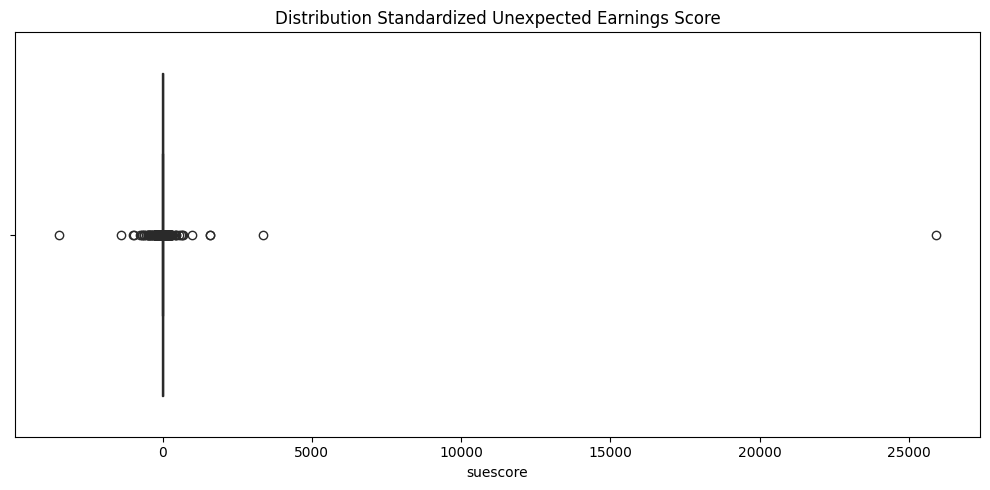

In [72]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=surp_sum['suescore'], orient='h', color='darkred')
ax.set_title('Distribution Standardized Unexpected Earnings Score')
plt.tight_layout()
plt.show()

**Fama-French Factor Returns**

We obtained the Fama-French factor returns (SMB, HML, RF and Mkt-RF) over the same data period as trading period (reference https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html).

In [73]:
ff_file_path = proj_dir/f"data/F-F_Research_Data_Factors_daily.csv"
ff_data = pd.read_csv(ff_file_path)
ff_data['date'] = pd.to_datetime(ff_data['date'], format='%Y%m%d')
display(ff_data.head())
display(ff_data.tail())

,date,Mkt-RF,SMB,HML,RF
0,1926-07-01,0.10,-0.25,-0.27,0.009
1,1926-07-02,0.45,-0.33,-0.06,0.009
2,1926-07-06,0.17,0.30,-0.39,0.009
3,1926-07-07,0.09,-0.58,0.02,0.009
4,1926-07-08,0.21,-0.38,0.19,0.009


,date,Mkt-RF,SMB,HML,RF
25875,2024-11-22,0.54,1.25,0.41,0.02
25876,2024-11-25,0.40,1.07,0.27,0.02
25877,2024-11-26,0.42,-0.92,-0.71,0.02
25878,2024-11-27,-0.39,0.28,0.47,0.02
25879,2024-11-29,0.54,0.14,-0.64,0.02


### Data Cleansing/Merge

#### Earnings Surprise Data
Below we are: 
- Converting "anndats" to a proper datetime, dropping any rows where it’s missing.
- Extracting the year from each announcement date, which we will use as a proxy for determining which data is consistent throughout.
- Filtering to keep only tickers that appear in every year of our date range   (year_beginning_filter through year_end_filter).
- Further ensuring each ticker has 4 quarters of data each year for consistently quarterly coverage.
- Removing any ticker that fails these conditions, leaving a final set of tickers meeting both the year coverage and 4-quarter criteria.
- Printing out the number of Investable universe of stocks for this dataset

In [102]:
# Cleaning the surprise Data
surp_sum['anndats'] = pd.to_datetime(surp_sum['anndats'], errors='coerce')
surp_sum = surp_sum[surp_sum['anndats'].notnull()]

surp_sum['year'] = surp_sum['anndats'].dt.year

years_required = set(range(year_beginning_filter, year_end_filter+1))

coverage = surp_sum.groupby('oftic')['year'].apply(set)
keep_tickers = coverage[coverage.apply(lambda x: years_required.issubset(x))].index
surp_sum = surp_sum[surp_sum['oftic'].isin(keep_tickers)]

quarter_counts = (
    surp_sum
    .groupby(['oftic', 'year'])
    .size()
    .reset_index(name='count_per_year')
)

quarter_counts_ok = quarter_counts[quarter_counts['count_per_year'] >= 4]

annual_coverage = quarter_counts_ok.groupby('oftic')['year'].apply(set)
keep_tickers_4q = annual_coverage[annual_coverage.apply(lambda x: years_required.issubset(x))].index

# Filtering out stocks that dont have 4 quarters of data for each year
surp_sum = surp_sum[surp_sum['oftic'].isin(keep_tickers_4q)]
surp_sum.drop(['ticker'], axis=1, inplace=True)
surp_sum['oftic'].nunique()

1747

##### Integrating Zack's Fundamental B Dataset
Below we are:
- Setting a market value threshold of $500 million to ensure our data stays above that amount throughout the entire date range.
- Calculating new metrics for use in rankings, P/E, EV/EBITDA, and YoY growth in revenue and price
- Ensuring we have consistent quarterly data for all the metrics below
- Printing out the unique amount of filters that pass these filters.
- We then filter the remaining tickers on what we have in the filtered surprise dataset to end up with 327 individual stocks that pass our criteria

In [103]:
zacks_cols = [
    'ticker',
    'per_end_date',
    'per_type',
    'tot_revnu',
    'eps_diluted_net',
    'basic_net_eps',
    'tot_lterm_debt',
    'net_lterm_debt',
    'net_curr_debt',
    'tot_debt_tot_equity',
    'ret_invst',
    'free_cash_flow_per_share',
    'ebitda',
    'shares_out',
    'mkt_val'
]

# Setting The Market Cap Threshold to Filter out Smaller Companies
mkt_cap_threshold = 500

# Selecting the metrics we plan to include in our strategy
zacks_df = zacks_data.loc[zacks_data.ticker.isin(top_tickers_list)].copy()
zacks_df = zacks_df[zacks_df['per_end_date'].notnull() & (zacks_df['per_type'] == 'Q')]
zacks_df.dropna(subset=zacks_cols, inplace=True)
zacks_df.sort_values(['ticker','per_end_date'], inplace=True)

zacks_df = zacks_df[zacks_df['per_end_date'].between(start_filing_date, end_filing_date)]

# Filtering Stocks to a smaller date range
zacks_df = zacks_df[zacks_df['per_end_date'].between(start_filter_date, end_filter_date)]
zacks_df['year'] = zacks_df['per_end_date'].dt.year


years_required = set(range(year_beginning_filter, year_end_filter + 1))
coverage = zacks_df.groupby('ticker')['year'].apply(set)
keep_tickers = coverage[coverage.apply(lambda s: years_required.issubset(s))].index
zacks_df = zacks_df[zacks_df['ticker'].isin(keep_tickers)]

zacks_df['ticker'].nunique()

268

In [104]:
# Filtering the surprise data on market cap requirement
valid_tickers = set(zacks_df['ticker'].unique())
surp_sum_filtered = surp_sum[surp_sum['oftic'].isin(valid_tickers)].reset_index(drop=True)

surp_sum_filtered['oftic'].nunique()

195

##### Transforming the primary final dataset
Below we are:
- Assign tickers to bins based on their avg_EPS to ensure we are comparing similar magnitudes of percent changes.
- We then transform the daily stock data obtained from the 'QUOTEMEDIA/PRICES' dataset to obtain the next day adjusted close and compute the return between those two days to capture the initial movement of the earnings surprise
- We merge these two datasets and bring in the relevant columns.
- The avg_eps_estimate is then calculated from subtracting the surprise mean from the actual EPS.
- Pct_surprise is calculated as the (average surprise)/ (the next day return)
- We then calculate the primary metric 'surprise_vs_move' which is simply the pct_surprise/(next day return). This should help us gauge how much the stock moved relative to it's surprise number
- The data is then translated into a z-score subtracting the mean of the bin it is in as well as dividing by the standard deviation of the same bin.

In [105]:
# # Separating the Surprises into Bins
# surp_sum_filtered['avg_eps'] = surp_sum_filtered.groupby('ticker')['actual'].transform('mean')
# bins = [-np.inf, 0, 0.5, 1, 2,  np.inf]
# labels = [
#     "Negative",
#     "0 to 0.5",
#     "0.5 to 1.0",
#     "1.0 to 2.0",
#     ">2.0"
# ]

# surp_sum_filtered['avg_eps_bin'] = pd.cut(surp_sum_filtered['avg_eps'], bins=bins, labels=labels)


# surp_sum_filtered.groupby('avg_eps_bin')['ticker'].nunique()

In [106]:
# Sorting close prices for merge
eod_data = top_eod_data.loc[top_eod_data.ticker.isin(surp_sum_filtered['oftic'].unique())].copy().reset_index(drop=True)

eod_data['date'] = pd.to_datetime(eod_data['date'])
surp_sum_filtered['anndats'] = pd.to_datetime(surp_sum_filtered['anndats'])

# Merging the surprise data with the EOD data
eod_surp_merged = pd.merge(
    eod_data[['ticker','date','adj_close']],
    surp_sum_filtered,
    how='left',
    left_on=['ticker','date'],
    right_on=['oftic','anndats']    
)

eod_surp_merged = eod_surp_merged.set_index(['ticker', 'date']).groupby(level=0).ffill().reset_index()

In [107]:
display(eod_surp_merged.head())
display(eod_surp_merged.tail())

,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year
0,AAOI,2018-01-02,37.91,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,AAOI,2018-01-03,37.89,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,AAOI,2018-01-04,38.38,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,AAOI,2018-01-05,38.89,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,AAOI,2018-01-08,38.37,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year
341634,ZG,2024-12-24,73.80,ZG,EPS,QTR,2024.0,9.0,1.0,2024-11-06,0.35,0.29238,0.02318,2.48567,2024.0
341635,ZG,2024-12-26,73.66,ZG,EPS,QTR,2024.0,9.0,1.0,2024-11-06,0.35,0.29238,0.02318,2.48567,2024.0
341636,ZG,2024-12-27,72.74,ZG,EPS,QTR,2024.0,9.0,1.0,2024-11-06,0.35,0.29238,0.02318,2.48567,2024.0
341637,ZG,2024-12-30,71.30,ZG,EPS,QTR,2024.0,9.0,1.0,2024-11-06,0.35,0.29238,0.02318,2.48567,2024.0
341638,ZG,2024-12-31,70.85,ZG,EPS,QTR,2024.0,9.0,1.0,2024-11-06,0.35,0.29238,0.02318,2.48567,2024.0


##### Merging the Fundamentals and Surprise Data
Below we are:
- Transforming the fundamental data and Earnings Surprise to ensure that we have a latest date for both to avoid lookahead bias in trades. To be safe we assume we are only available to trade on this information after the announcement and filing date.
- Both of the datasets are then merged on 'ticker' and 'oftic'.
- Trade day is then calculated as the latest day between the two announcements
- Calculate Z_scores for new metrics within bins
- We then drop incomplete rows and features for a final cleanup.

In [108]:
zacks_df['valid_from'] = zacks_df['filing_date'] + pd.Timedelta(days=1)

fund_data = zacks_df[zacks_cols+['valid_from']].copy()

surp_data = eod_surp_merged.copy()

surp_data_sorted = surp_data.sort_values(by="date")
fund_data_sorted = fund_data.sort_values(by="valid_from")

merged_df = pd.merge(
    surp_data_sorted,
    fund_data_sorted,
    how='left',
    left_on=['ticker','date'],
    right_on=['ticker','valid_from']    
)

merged_df = merged_df.set_index(['ticker', 'date']).groupby(level=0).ffill().reset_index()

In [109]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341640 entries, 0 to 341639
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ticker                    341640 non-null  object        
 1   date                      341640 non-null  datetime64[ns]
 2   adj_close                 341640 non-null  float64       
 3   oftic                     336270 non-null  object        
 4   measure                   336270 non-null  object        
 5   fiscalp                   336270 non-null  object        
 6   pyear                     336270 non-null  float64       
 7   pmon                      336270 non-null  float64       
 8   usfirm                    336270 non-null  float64       
 9   anndats                   336270 non-null  datetime64[ns]
 10  actual                    336270 non-null  float64       
 11  surpmean                  336270 non-null  float64       
 12  su

In [110]:
# Identifying tickers that have missing rev_yoy_growth or price_yoy_growth
tickers_with_na = (
    merged_df
    .loc[(merged_df.isna().any(axis=1)) & (merged_df.date>=data_start_date) & (merged_df.date<=data_end_date), 'ticker']
    .unique()
)

# # Dropping all rows belonging to these tickers
merged_df = merged_df[~merged_df['ticker'].isin(tickers_with_na)]

In [111]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 227169 entries, 0 to 341639
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ticker                    227169 non-null  object        
 1   date                      227169 non-null  datetime64[ns]
 2   adj_close                 227169 non-null  float64       
 3   oftic                     223521 non-null  object        
 4   measure                   223521 non-null  object        
 5   fiscalp                   223521 non-null  object        
 6   pyear                     223521 non-null  float64       
 7   pmon                      223521 non-null  float64       
 8   usfirm                    223521 non-null  float64       
 9   anndats                   223521 non-null  datetime64[ns]
 10  actual                    223521 non-null  float64       
 11  surpmean                  223521 non-null  float64       
 12  surpstd

In [112]:
display(merged_df.describe())
display(merged_df.info())

,date,adj_close,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from
count,227169,227169.000000,223521.000000,223521.000000,223521.0,223521,223521.000000,223521.000000,223521.000000,223521.000000,223521.000000,212061,212061.000000,212061.000000,212061.000000,212061.000000,212061.000000,212061.000000,212061.000000,212061.000000,212061.000000,212061.000000,212061.000000,2.120610e+05,212061
mean,2021-07-01 15:36:17.172061440,83.290064,2020.731918,7.364248,1.0,2021-06-06 21:53:41.093320704,1.170675,1.090781,0.088005,1.476965,2020.952282,2021-02-10 20:09:38.754226432,4232.198067,0.694976,0.700009,9397.066335,368.719323,103.316249,2.126706,1.785325,1.687783,864.992884,476.763353,4.508385e+04,2021-03-22 08:23:39.893332736
min,2018-01-02 00:00:00,1.040000,2017.000000,3.000000,1.0,2018-01-18 00:00:00,-10.440000,-10.521400,0.000000,-94.046100,2018.000000,2018-03-31 00:00:00,-357.000000,-20.960000,-20.960000,0.021000,-17199.000000,-22642.000000,-611.650000,-29.669200,-34.148800,-19305.000000,12.110000,5.410000e+01,2018-04-19 00:00:00
25%,2019-10-02 00:00:00,30.532143,2019.000000,3.000000,1.0,2019-10-16 00:00:00,0.430000,0.396000,0.024630,-0.111980,2019.000000,2019-06-30 00:00:00,682.405000,0.210000,0.220000,1295.300000,-44.500000,-100.000000,0.584900,0.568100,-0.552700,87.238000,63.940000,3.080060e+03,2019-08-09 00:00:00
50%,2021-07-01 00:00:00,56.750697,2021.000000,6.000000,1.0,2021-05-10 00:00:00,0.850000,0.786440,0.046210,1.079940,2021.000000,2020-09-30 00:00:00,1596.000000,0.690000,0.700000,3513.530000,0.550000,0.640000,1.125300,1.628400,0.984100,269.000000,177.900000,8.658080e+03,2020-12-02 00:00:00
75%,2023-03-31 00:00:00,108.508164,2022.000000,9.000000,1.0,2023-02-21 00:00:00,1.560000,1.467500,0.097460,2.821350,2023.000000,2022-09-30 00:00:00,4151.000000,1.300000,1.310000,10299.000000,511.000000,143.000000,1.897600,3.107200,3.201000,852.777000,392.120000,2.741739e+04,2022-11-03 00:00:00
max,2024-12-31 00:00:00,958.350400,2024.000000,12.000000,1.0,2024-11-14 00:00:00,17.180000,12.894400,3.795910,42.899650,2024.000000,2024-09-30 00:00:00,91819.000000,16.280000,16.280000,105752.000000,27380.000000,48256.900000,459.480300,37.681200,92.216200,28385.000000,19319.720000,2.263972e+06,2024-11-22 00:00:00
std,NaN,83.934252,2.015584,3.279961,0.0,NaN,1.435480,1.290044,0.162817,4.560138,1.977989,NaN,8614.624929,2.203923,2.225439,15372.010323,2044.447160,2390.219938,18.732826,5.284895,6.201952,2478.870651,1545.540956,1.687690e+05,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 227169 entries, 0 to 341639
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ticker                    227169 non-null  object        
 1   date                      227169 non-null  datetime64[ns]
 2   adj_close                 227169 non-null  float64       
 3   oftic                     223521 non-null  object        
 4   measure                   223521 non-null  object        
 5   fiscalp                   223521 non-null  object        
 6   pyear                     223521 non-null  float64       
 7   pmon                      223521 non-null  float64       
 8   usfirm                    223521 non-null  float64       
 9   anndats                   223521 non-null  datetime64[ns]
 10  actual                    223521 non-null  float64       
 11  surpmean                  223521 non-null  float64       
 12  surpstd

None

In [113]:
merged_df.to_parquet('../data/merged_data.parquet')
merged_df = pd.read_parquet('../data/merged_data.parquet')

## **Feature Engineering**

To capture disposition effect and underreaction to news, we will constrcut factors incorporating fundamental, earnings, and price data.

1. Disposition Effect Signals
- Capital Gains Overhang:
    - Compute unrealized capital gains/losses using mutual fund holdings (due to limited data we are using a reference price instaed) and stock price history.
    - $CGO = (Current Price - Weighted Average Purchase Price) / Current Price$
    - Stocks with large unrealized losses tend to underreact to bad news.
- Realized vs. Unrealized Gains Ratio:
    - High values: Investors aggressively taking profits (possible reversal).
    - Low values: Investors reluctant to realize losses (potential underreaction).

2. PEAD Signals
- Earnings Surprise (SUE - Standardized Unexpected Earnings):
    - $SUE = (Actual\ EPS - Expected\ EPS) / Std\ of\ EPS\ Estimates$
    - Higher SUE: Stronger PEAD effects
- Earnings Drift Factor:
    - Stocks with high past earnings surprise but low short-term reaction may exhibit PEAD.
    - Compute cumulative abnormal returns (CAR) post-earnings
        - We will test different window lengths (5-day, 30-day, etc)

3. Momentum & Technical Signals
- N-Month Momentum: Stocks with strong past N-month returns tend to continue moving in the same direction.
- Relative Strength Index: Captures overbought/oversold condition
    - We will test different windows here
- Short-Term Reversals: Compute N-week return to detect extreme short-term movements

4. Fundamentals


\begin{array}{|l|l|l|}
\hline
\textbf{Feature Name} & \textbf{Definition} & \textbf{Purpose} \\
\hline
ps\ ratio & \text{Market Value / Total Revenue} & \text{Valuation} \\
earnings\ yield & \text{EPS / Market Value per Share} & \text{Valuation} \\
fcf\ yield & \text{Free Cash Flow per Share / Market Value per Share} & \text{Valuation} \\
ebitda\ margin & \text{EBITDA / Total Revenue} & \text{Profitability} \\
roi\ scaled & \text{Return on Investment} & \text{Profitability} \\
eps\ growth & \text{YoY EPS Growth} & \text{Growth} \\
debt\ to\ equity & \text{Total Debt / Total Equity} & \text{Leverage} \\
net\ debt\ to\ ebitda & \text{(Net LT Debt + Net Current Debt) / EBITDA} & \text{Leverage} \\
debt\ to\ revenue & \text{Total LT Debt / Total Revenue} & \text{Leverage} \\
revenue\ growth & \text{YoY Revenue Growth} & \text{Growth} \\
ebitda\ growth & \text{YoY EBITDA Growth} & \text{Growth} \\
mkt\ cap\ growth & \text{YoY Market Cap Growth} & \text{Growth} \\
log\ mkt\ cap & \text{Log of Market Cap} & \text{Size Indicator} \\
fcf\ growth & \text{YoY Free Cash Flow Growth} & \text{Growth} \\
\hline
\end{array}

In [72]:
merged_df = pd.read_parquet('../data/merged_data_official.parquet')
merged_df.head()

,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,per_type,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from
0,AAOI,2018-01-02,37.910000,None,None,None,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,SCI,2018-01-02,33.605937,None,None,None,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,CCI,2018-01-02,81.755975,None,None,None,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,CAT,2018-01-02,133.901045,None,None,None,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
6,CACI,2018-01-02,134.150000,None,None,None,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaT,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [73]:
merged_df[merged_df['ticker']=='AAPL'].tail(20)

,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,per_type,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from
343239,AAPL,2024-12-03,242.65,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30
343341,AAPL,2024-12-04,243.01,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30
343631,AAPL,2024-12-05,243.04,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30
343873,AAPL,2024-12-06,242.84,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30
344031,AAPL,2024-12-09,246.75,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30
344321,AAPL,2024-12-10,247.77,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30
344444,AAPL,2024-12-11,246.49,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30
344534,AAPL,2024-12-12,247.96,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30
344764,AAPL,2024-12-13,248.13,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30
345068,AAPL,2024-12-16,251.04,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30


In [74]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230793 entries, 0 to 347082
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   ticker                    230793 non-null  object        
 1   date                      230793 non-null  datetime64[ns]
 2   adj_close                 230793 non-null  float64       
 3   oftic                     227056 non-null  object        
 4   measure                   227056 non-null  object        
 5   fiscalp                   227056 non-null  object        
 6   pyear                     227056 non-null  float64       
 7   pmon                      227056 non-null  float64       
 8   usfirm                    227056 non-null  float64       
 9   anndats                   227056 non-null  datetime64[ns]
 10  actual                    227056 non-null  float64       
 11  surpmean                  227056 non-null  float64       
 12  surpstd

In [75]:
# Define window for reference price
window = 65

# Compute rolling average price (proxy for purchase price)
merged_df['ref_price'] = merged_df.groupby('ticker')['adj_close'].transform(lambda x: x.rolling(window).mean())

# Compute Capital Gains Overhang
merged_df['cgo'] = (merged_df['adj_close'] - merged_df['ref_price']) / merged_df['adj_close']

In [76]:
# Define rolling window lengths
momentum_windows = [21, 126, 252]  # 1-month, 6-month, 12-month

# Compute momentum factors (log returns)
for window in momentum_windows:
    merged_df[f'mom_{window}'] = merged_df.groupby('ticker')['adj_close'].transform(lambda x: np.log(x / x.shift(window)))

# Compute short-term reversal (1-week return)
merged_df['short_term_reversal'] = merged_df.groupby('ticker')['adj_close'].transform(lambda x: np.log(x / x.shift(5)))

In [77]:
# Compute cumulative abnormal return (CAR) post earnings
windows = [5, 20]  # 5-day and 30-day drift

for w in windows:
    merged_df[f'pead_{w}d'] = merged_df.groupby('ticker')['adj_close'].transform(lambda x: x.pct_change(w))

In [78]:
merged_df['ps_ratio'] = merged_df['mkt_val'] / merged_df['tot_revnu']
merged_df['earnings_yield'] = merged_df['eps_diluted_net'] / (merged_df['mkt_val'] / merged_df['shares_out'])
merged_df['fcf_yield'] = merged_df['free_cash_flow_per_share'] / (merged_df['mkt_val'] / merged_df['shares_out'])
merged_df['ebitda_margin'] = merged_df['ebitda'] / merged_df['tot_revnu']
merged_df['roi_scaled'] = merged_df['ret_invst'] / 100
merged_df['eps_growth'] = merged_df.groupby('ticker')['eps_diluted_net'].pct_change(4)
merged_df['net_debt_to_ebitda'] = (merged_df['net_lterm_debt'] + merged_df['net_curr_debt']) / merged_df['ebitda']
merged_df['debt_to_revenue'] = merged_df['tot_lterm_debt'] / merged_df['tot_revnu']
merged_df['revenue_growth'] = merged_df.groupby('ticker')['tot_revnu'].pct_change(4)
merged_df['ebitda_growth'] = merged_df.groupby('ticker')['ebitda'].pct_change(4)
merged_df['mkt_cap_growth'] = merged_df.groupby('ticker')['mkt_val'].pct_change(4)
merged_df['log_mkt_cap'] = np.log(merged_df['mkt_val'])
merged_df['fcf_growth'] = merged_df.groupby('ticker')['free_cash_flow_per_share'].pct_change(4)

In [79]:
merged_df[merged_df['ticker']=='AAPL'].tail(20)

,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,per_type,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from,ref_price,cgo,mom_21,mom_126,mom_252,short_term_reversal,pead_5d,pead_20d,ps_ratio,earnings_yield,fcf_yield,ebitda_margin,roi_scaled,eps_growth,net_debt_to_ebitda,debt_to_revenue,revenue_growth,ebitda_growth,mkt_cap_growth,log_mkt_cap,fcf_growth
343239,AAPL,2024-12-03,242.65,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30,227.583433,0.062092,0.085953,0.224209,0.242975,0.041140,0.041998,0.094173,27.801308,0.009492,0.033056,0.331041,0.127882,0.0,0.35036,1.298622,0.0,0.0,0.0,14.632631,0.0
343341,AAPL,2024-12-04,243.01,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30,227.898589,0.062184,0.091481,0.217901,0.253967,0.033262,0.033821,0.088734,27.801308,0.009492,0.033056,0.331041,0.127882,0.0,0.35036,1.298622,0.0,0.0,0.0,14.632631,0.0
343631,AAPL,2024-12-05,243.04,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30,228.243712,0.060880,0.085139,0.225146,0.233246,0.033938,0.034521,0.092438,27.801308,0.009492,0.033056,0.331041,0.127882,0.0,0.35036,1.298622,0.0,0.0,0.0,14.632631,0.0
343873,AAPL,2024-12-06,242.84,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30,228.562246,0.058795,0.087588,0.212007,0.238127,0.022951,0.023217,0.068698,27.801308,0.009492,0.033056,0.331041,0.127882,0.0,0.35036,1.298622,0.0,0.0,0.0,14.632631,0.0
344031,AAPL,2024-12-09,246.75,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30,228.964907,0.072077,0.082414,0.247313,0.244011,0.029447,0.029884,0.087196,27.801308,0.009492,0.033056,0.331041,0.127882,0.0,0.35036,1.298622,0.0,0.0,0.0,14.632631,0.0
344321,AAPL,2024-12-10,247.77,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30,229.381877,0.074214,0.087727,0.181307,0.240751,0.020881,0.021100,0.104981,27.801308,0.009492,0.033056,0.331041,0.127882,0.0,0.35036,1.298622,0.0,0.0,0.0,14.632631,0.0
344444,AAPL,2024-12-11,246.49,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30,229.791449,0.067745,0.094649,0.147950,0.248583,0.014219,0.014320,0.099273,27.801308,0.009492,0.033056,0.331041,0.127882,0.0,0.35036,1.298622,0.0,0.0,0.0,14.632631,0.0
344534,AAPL,2024-12-12,247.96,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30,230.184449,0.071687,0.100595,0.148420,0.246641,0.020041,0.020244,0.101457,27.801308,0.009492,0.033056,0.331041,0.127882,0.0,0.35036,1.298622,0.0,0.0,0.0,14.632631,0.0
344764,AAPL,2024-12-13,248.13,AAPL,EPS,QTR,2024.0,9.0,1.0,2024-10-31,1.64,1.60228,0.02825,1.33532,2024.0,2021-06-30,Q,81434.0,1.3,1.31,105752.0,6423.0,3022.0,1.8947,12.7882,4.5273,26958.0,16530.17,2263971.75,2021-07-30,230.578374,0.070736,0.097319,0.157307,0.230772,0.021550,0.021784,0.087240,27.801308,0.009492,0.033056,0.331041,0.127882,0.0,0.35036,1.2986

In [80]:
prediction_target_windows = [5, 20, 60]
feature_importance_dict = {}

for w in prediction_target_windows:
    prediction_target_window = w
    merged_df[f'target_return_{w}_day'] = merged_df.groupby('ticker')['adj_close'].pct_change(w)
    merged_df[f'target_return_{w}_day'] = merged_df.groupby('ticker')[f'target_return_{w}_day'].shift(-w)

In [81]:
merged_df[merged_df['ticker']=='AAPL'][['date','adj_close', 'target_return_5_day']].tail(10)

,date,adj_close,target_return_5_day
345163,2024-12-17,253.48,0.018621
345382,2024-12-18,248.05,0.044225
345531,2024-12-19,249.79,0.023220
345837,2024-12-20,254.49,-0.008998
345921,2024-12-23,255.27,-0.018999
346248,2024-12-24,258.20,NaN
346357,2024-12-26,259.02,NaN
346688,2024-12-27,255.59,NaN
346771,2024-12-30,252.20,NaN
347010,2024-12-31,250.42,NaN


In [82]:
merged_df['day_after_earnings']= merged_df.groupby(['ticker', 'anndats'])['date'].nth(1)
merged_df['day_after_earnings'] = merged_df.groupby('ticker')['day_after_earnings'].ffill()
merged_df['previous_day_return'] = merged_df.groupby('ticker')['adj_close'].pct_change()
merged_df[merged_df['ticker']=='AAPL'][['date','anndats', 'day_after_earnings']].tail(20)

,date,anndats,day_after_earnings
343239,2024-12-03,2024-10-31,2024-11-01
343341,2024-12-04,2024-10-31,2024-11-01
343631,2024-12-05,2024-10-31,2024-11-01
343873,2024-12-06,2024-10-31,2024-11-01
344031,2024-12-09,2024-10-31,2024-11-01
344321,2024-12-10,2024-10-31,2024-11-01
344444,2024-12-11,2024-10-31,2024-11-01
344534,2024-12-12,2024-10-31,2024-11-01
344764,2024-12-13,2024-10-31,2024-11-01
345068,2024-12-16,2024-10-31,2024-11-01


In [83]:
final_df = merged_df.loc[(merged_df['date']>=data_start_date) & (merged_df['date']<=data_end_date) & (merged_df['day_after_earnings']==merged_df['date'])].copy().reset_index(drop=True)
final_df = final_df.dropna(subset=[f'target_return_{w}_day' for w in prediction_target_windows])
display(final_df.head())
display(final_df.tail())
display(final_df.describe())

,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,per_type,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from,ref_price,cgo,mom_21,mom_126,mom_252,short_term_reversal,pead_5d,pead_20d,ps_ratio,earnings_yield,fcf_yield,ebitda_margin,roi_scaled,eps_growth,net_debt_to_ebitda,debt_to_revenue,revenue_growth,ebitda_growth,mkt_cap_growth,log_mkt_cap,fcf_growth,target_return_5_day,target_return_20_day,target_return_60_day,day_after_earnings,previous_day_return
0,SLB,2019-01-18,38.161562,SLB,EPS,QTR,2018.0,12.0,1.0,2019-01-18,0.36,0.35564,0.01170,0.37228,2019.0,2018-09-30,Q,8504.00,0.46,0.46,14159.000,-680.000,-103.000,0.4702,1.2875,1.3240,1785.0000,1384.80,84362.02,2018-10-26,38.664135,-0.013170,0.168600,-0.377021,-0.536036,0.079298,0.082527,0.235635,9.920275,0.007551,0.021733,0.209901,0.012875,0.0,-0.438655,1.664981,0.0,0.0,0.0,11.342873,0.0,-0.010955,0.029662,0.070360,2019-01-18,0.000000
1,VFC,2019-01-22,67.251991,VFC,EPS,QTR,2018.0,12.0,1.0,2019-01-18,1.31,1.09777,0.03034,6.99520,2019.0,2018-09-30,Q,3219.39,1.26,1.28,2150.595,-3.107,40.219,0.8904,6.5737,-0.0663,621.3491,396.81,37081.52,2018-11-02,63.862911,0.050394,0.129469,-0.116226,0.048122,0.132396,0.141561,0.167309,11.518182,0.013483,-0.000709,0.193002,0.065737,0.0,0.059728,0.668013,0.0,0.0,0.0,10.520874,0.0,0.028250,0.056255,0.174917,2019-01-22,-0.006923
2,JNJ,2019-01-23,109.848885,JNJ,EPS,QTR,2018.0,12.0,1.0,2019-01-22,1.97,1.95181,0.01481,1.22839,2019.0,2018-09-30,Q,20348.00,1.44,1.44,29480.000,-904.000,-2325.000,0.4836,4.1804,5.3160,6572.0000,2681.98,370569.16,2018-11-02,116.812080,-0.063389,0.004123,0.029986,-0.113180,-0.004338,-0.004329,0.005543,18.211577,0.010422,0.038474,0.322980,0.041804,0.0,-0.491327,1.448791,0.0,0.0,0.0,12.822795,0.0,0.022050,0.051398,0.074757,2019-01-23,0.000000
3,ATI,2019-01-23,26.440000,ATI,EPS,QTR,2018.0,12.0,1.0,2019-01-22,0.31,0.34455,0.03725,-0.92749,2019.0,2018-09-30,Q,1020.20,0.37,0.40,1535.300,2.500,4.000,0.7450,1.5365,0.1144,133.3000,125.68,3713.96,2018-11-02,25.077692,0.051524,0.183836,-0.013524,-0.064089,0.079885,0.083163,0.216191,3.640423,0.012521,0.003871,0.130661,0.015365,0.0,0.048762,1.504901,0.0,0.0,0.0,8.219854,0.0,0.031392,0.085098,-0.027231,2019-01-23,0.032812
4,IBM,2019-01-23,95.875301,IBM,EPS,QTR,2018.0,12.0,1.0,2019-01-22,4.87,4.81706,0.10123,0.52299,2019.0,2018-09-30,Q,18756.00,2.94,2.95,35989.000,468.000,376.000,2.3557,4.8151,9.5138,4327.0000,908.79,137418.75,2018-11-01,86.571425,0.097041,0.161957,-0.068597,-0.157280,0.087716,0.091678,0.197855,7.326655,0.019443,0.062918,0.230700,0.048151,0.0,0.195054,1.918799,0.0,0.0,0.0,11.830788,0.0,0.011212,0.049476,0.068434,2019-01-23,0.084639


,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,per_type,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from,ref_price,cgo,mom_21,mom_126,mom_252,short_term_reversal,pead_5d,pead_20d,ps_ratio,earnings_yield,fcf_yield,ebitda_margin,roi_scaled,eps_growth,net_debt_to_ebitda,debt_to_revenue,revenue_growth,ebitda_growth,mkt_cap_growth,log_mkt_cap,fcf_growth,target_return_5_day,target_return_20_day,target_return_60_day,day_after_earnings,previous_day_return
3207,PEG,2024-08-19,79.727247,PEG,EPS,QTR,2024.0,6.0,0.0,2024-08-16,-0.01,0.00000,0.06083,-0.04110,2024.0,2024-03-31,Q,2760.000,1.06,1.07,18764.000,2000.000,-425.0,1.3862,1.5428,-0.2720,1058.0000,498.08,33261.81,2024-05-02,74.492019,0.065664,0.080290,0.311280,0.319650,0.004585,0.004596,0.066737,12.051380,0.015873,-0.004073,0.383333,0.015428,0.0,1.488658,6.798551,0.0,0.0,0.0,10.412165,0.0,0.001978,0.055417,0.080330,2024-08-19,0.003474
3208,EL,2024-08-20,89.883445,EL,EPS,QTR,2024.0,6.0,1.0,2024-08-19,0.64,0.26582,0.06174,6.06100,2024.0,2024-03-31,Q,3940.000,0.91,0.92,7265.000,-143.000,-215.0,1.3527,2.5751,2.1314,737.0000,358.56,55272.63,2024-05-03,106.633576,-0.186354,-0.104987,-0.462494,-0.530003,-0.010389,-0.010335,-0.089936,14.028586,0.005903,0.013827,0.187056,0.025751,0.0,-0.485753,1.843909,0.0,0.0,0.0,10.920033,0.0,0.020886,-0.025683,-0.304027,2024-08-20,-0.020248
3209,CHEF,2024-08-21,39.520000,CHEF,EPS,QTR,2024.0,6.0,0.0,2024-08-20,1.08,1.08000,0.02381,1.68032,2024.0,2024-06-30,Q,954.704,0.37,0.41,660.759,-3.026,-14.5,1.5532,1.3828,0.5899,49.5749,39.83,1557.61,2024-08-02,39.425846,0.002382,-0.079965,0.082238,0.312965,0.053266,0.054710,-0.054772,1.631511,0.009461,0.015084,0.051927,0.013828,0.0,-0.353526,0.692109,0.0,0.0,0.0,7.350908,0.0,0.067561,0.026063,0.048330,2024-08-21,0.028631
3210,OSIS,2024-08-23,150.000000,OSIS,EPS,QTR,2024.0,6.0,1.0,2024-08-22,2.84,2.79125,0.01031,4.72934,2024.0,2024-03-31,Q,405.406,1.95,1.95,131.214,-5.138,134.0,0.6005,3.6039,-4.1187,61.9920,17.05,2434.90,2024-05-02,141.296923,0.058021,0.017350,0.129426,0.221728,0.040683,0.041522,-0.002195,6.006078,0.013655,-0.028841,0.152913,0.036039,0.0,2.078688,0.323661,0.0,0.0,0.0,7.797661,0.0,-0.000867,-0.027600,0.014800,2024-08-23,-0.027742
3211,PPL,2024-09-23,32.585119,PPL,EPS,QTR,2024.0,6.0,0.0,2024-09-20,6.73,9.61500,0.23335,-12.36367,2024.0,2024-03-31,Q,2304.000,0.42,0.42,15753.000,1148.000,-701.0,1.1413,1.0298,-0.4250,885.0000,737.74,20310.01,2024-05-03,29.744017,0.087190,0.048049,0.209929,0.303353,0.004884,0.004896,0.041301,8.815109,0.015256,-0.015438,0.384115,0.010298,0.0,0.505085,6.837240,0.0,0.0,0.0,9.918869,0.0,0.007308,-0.003350,-0.009978,2024-09-23,0.011707


,date,adj_close,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from,ref_price,cgo,mom_21,mom_126,mom_252,short_term_reversal,pead_5d,pead_20d,ps_ratio,earnings_yield,fcf_yield,ebitda_margin,roi_scaled,eps_growth,net_debt_to_ebitda,debt_to_revenue,revenue_growth,ebitda_growth,mkt_cap_growth,log_mkt_cap,fcf_growth,target_return_5_day,target_return_20_day,target_return_60_day,day_after_earnings,previous_day_return
count,3212,3212.000000,3212.000000,3212.000000,3212.000000,3212,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3.212000e+03,3212,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3188.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000,3212,3212.000000
mean,2021-11-04 15:03:48.642589952,88.298678,2021.130448,7.438356,0.918431,2021-11-03 12:57:49.987546624,1.188448,1.112621,0.098198,1.473302,2021.392590,2021-02-13 22:00:17.932752384,4337.703519,0.755882,0.761728,9502.159514,376.290903,92.751224,2.109319,1.739610,2.026525,847.611070,471.067889,4.459074e+04,2021-03-25 23:47:53.723536896,86.916117,0.002480,0.022934,0.030936,0.053593,0.001355,0.004528,0.028513,9.458085,-0.001421,0.015666,0.198318,0.017396,-0.008208,1.008041,4.519251,0.000164,0.002628,0.000111,9.213782,-0.107002,0.005049,0.009568,0.033605,2021-11-04 15:03:48.642589952,0.000406
min,2019-01-18 00:00:00,1.340000,2018.000000,3.000000,0.000000,2019-01-18 00:00:00,-7.690000,-6.687140,0.000000,-94.046100,2019.000000,2018-03-31 00:00:00,-357.000000,-20.960000,-20.960000,0.021000,-17199.000000,-22642.000000,-611.650000,-29.669200,-34.148800,-19305.000000,12.110000,5.410000e+01,2018-04-19 00:00:00,1.358923,-2.299473,-0.880498,-1.668826,-3.535551,-0.525560,-0.408776,-0.545407,-157.211092,-1.304158,-1.549965,-5.477647,-0.296692,-20.086957,-557.856644,-16.226891,-0.190122,-0.635753,-0.400198,3.990834,-329.400000,-0.584317,-0.802574,-0.801796,2019-01-18 00:00:00,-0.389547
25%,2020-05-07 00:00:00,30.143750,2020.000000,3.000000,1.000000,2020-05-06 00:00:00,0.390000,0.353375,0.025773,-0.235235,2020.000000,2019-09-30 00:00:00,701.399000,0.200000,0.210000,1529.673000,-45.158500,-98.250000,0.626950,0.531775,-0.453400,94.111000,69.390000,3.080060e+03,2019-11-01 00:00:00,29.841543,-0.045877,-0.035464,-0.090220,-0.111774,-0.036859,-0.036188,-0.034899,3.389330,0.004361,-0.010095,0.103696,0.005318,0.000000,-0.427617,1.077189,0.000000,0.000000,0.000000,8.032704,0.000000,-0.021623,-0.042830,-0.063821,2020-05-07 00:00:00,-0.018927
50%,2021-11-03 00:00:00,57.646342,2021.000000,6.000000,1.000000,2021-11-02 00:00:00,0.830000,0.763230,0.050000,1.024985,2021.000000,2020-12-31 00:00:00,1576.500000,0.690000,0.700000,3576.391500,4.000000,0.640000,1.163400,1.614650,1.030700,269.369500,156.340000,8.902010e+03,2021-02-11 00:00:00,56.788260,0.016465,0.022977,0.037287,0.060859,0.004058,0.004066,0.022100,6.962398,0.010566,0.016119,0.183721,0.016147,0.000000,0.240968,1.900009,0.000000,0.000000,0.000000,9.094032,0.000000,0.004214,0.011478,0.026136,2021-11-03 00:00:00,0.000000
75%,2023-04-28 00:00:00,113.298888,2023.000000,12.000000,1.000000,2023-04-27 00:00:00,1.540000,1.466565,0.107717,2.804570,2023.000000,2022-06-30 00:00:00,4167.708250,1.300000,1.310000,10824.000000,640.900000,135.050000,1.894700,3.101575,3.183550,858.250000,388.660000,2.773289e+04,2022-08-10 00:00:00,112.841039,0.066655,0.081505,0.164695,0.228511,0.042379,0.043290,0.081312,12.548256,0.017633,0.047885,0.305512,0.031016,0.000000,1.606076,4.696158,0.000000,0.000000,0.000000,10.230374,0.000000,0.031219,0.060069,

In [84]:
final_df[final_df['ticker']=='AAPL'].tail(20)

,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,per_type,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from,ref_price,cgo,mom_21,mom_126,mom_252,short_term_reversal,pead_5d,pead_20d,ps_ratio,earnings_yield,fcf_yield,ebitda_margin,roi_scaled,eps_growth,net_debt_to_ebitda,debt_to_revenue,revenue_growth,ebitda_growth,mkt_cap_growth,log_mkt_cap,fcf_growth,target_return_5_day,target_return_20_day,target_return_60_day,day_after_earnings,previous_day_return
479,AAPL,2019-10-31,60.114750,AAPL,EPS,QTR,2019.0,9.0,1.0,2019-10-30,0.7575,0.70984,0.01366,3.48965,2019.0,2019-06-30,Q,53809.0,0.545,0.55,84936.0,-5500.0,-2026.0,1.1240,5.5372,2.2690,14477.0,18076.72,894436.06,2019-08-02,53.075283,0.117100,0.127600,0.168803,0.169280,0.021043,0.021266,0.126528,16.622425,0.011015,0.045857,0.269044,0.055372,0.0,-0.519859,1.578472,0.0,0.0,0.0,13.703949,0.0,0.045988,0.077517,0.307697,2019-10-31,0.022610
577,AAPL,2020-01-29,78.611866,AAPL,EPS,QTR,2019.0,12.0,1.0,2020-01-28,1.2475,1.13685,0.02437,4.54013,2020.0,2019-06-30,Q,53809.0,0.545,0.55,84936.0,-5500.0,-2026.0,1.1240,5.5372,2.2690,14477.0,18076.72,894436.06,2019-08-02,67.859618,0.136776,0.112601,0.447299,0.755393,0.020685,0.020900,0.112582,16.622425,0.011015,0.045857,0.269044,0.055372,0.0,-0.519859,1.578472,0.0,0.0,0.0,13.703949,0.0,-0.008910,-0.154658,-0.125452,2020-01-29,0.020932
755,AAPL,2020-05-01,70.231878,AAPL,EPS,QTR,2020.0,3.0,1.0,2020-04-30,0.6375,0.56528,0.06421,1.12489,2020.0,2019-12-31,Q,91819.0,1.250,1.26,93078.0,1210.0,-979.0,1.2095,12.1768,1.5944,28385.0,17501.92,1284859.63,2020-01-31,68.498808,0.024676,0.182245,0.177905,0.336705,0.021328,0.021557,0.180215,13.993396,0.017027,0.021718,0.309141,0.121768,0.0,0.008138,1.013712,0.0,0.0,0.0,14.066160,0.0,0.075691,0.116342,0.293791,2020-05-01,-0.016099
907,AAPL,2020-07-31,103.539925,AAPL,EPS,QTR,2020.0,6.0,1.0,2020-07-30,0.6450,0.51089,0.03721,3.60393,2020.0,2019-12-31,Q,91819.0,1.250,1.26,93078.0,1210.0,-979.0,1.2095,12.1768,1.5944,28385.0,17501.92,1284859.63,2020-01-31,84.346128,0.185376,0.154727,0.322237,0.724411,0.137438,0.147330,0.167340,13.993396,0.017027,0.021718,0.309141,0.121768,0.0,0.008138,1.013712,0.0,0.0,0.0,14.066160,0.0,0.047596,0.176715,0.084719,2020-07-31,0.104689
1034,AAPL,2020-10-30,106.269072,AAPL,EPS,QTR,2020.0,9.0,1.0,2020-10-29,0.7300,0.70022,0.06420,0.46389,2020.0,2019-12-31,Q,91819.0,1.250,1.26,93078.0,1210.0,-979.0,1.2095,12.1768,1.5944,28385.0,17501.92,1284859.63,2020-01-31,113.348160,-0.066615,-0.070315,0.400122,0.569719,-0.055217,-0.053720,-0.036808,13.993396,0.017027,0.021718,0.309141,0.121768,0.0,0.008138,1.013712,0.0,0.0,0.0,14.066160,0.0,0.092183,0.095495,0.261499,2020-10-30,-0.056018
1133,AAPL,2021-01-28,134.058328,AAPL,EPS,QTR,2020.0,12.0,1.0,2021-01-27,1.6800,1.41153,0.07101,3.78079,2021.0,2019-12-31,Q,91819.0,1.250,1.26,93078.0,1210.0,-979.0,1.2095,12.1768,1.5944,28385.0,17501.92,1284859.63,2020-01-31,121.828228,0.091230,0.002922,0.369909,0.533752,0.001606,0.001607,0.016460,13.993396,0.017027,0.021718,0.309141,0.121768,0.0,0.008138,1.013712,0.0,0.0,0.0,14.066160,0.0,0.002188,-0.114146,-0.015815,2021-01-28,-0.034985
1302,AAPL,2021-04-29,130.723820,AAPL,EPS,QTR,2021.0,3.0,1.0,2021-04-28,1.4000,0.98669,0.05578,7.40925,2021.0,2019-12-31,Q,91819.0,1.250,1.26,93078.0,1210.0,-979.0,1.2095,12.1768,1.5944,28385.0,17501.92,1284859.63,2020-01-31,125.785263,0.037779,0.107294,0.138426,0.625931,0.011604,0.011672,0.092755,13.993396,0.017027,0.021718,0.309141,0.121768,0.0,0.008138,1.013712,0.0,0.0,0.0,14.066160,0.0,-0.028019,-0.059847,0.118083,2021-04-29,-0.000749
1423,AAPL,2021-07-28,142.226257,AAPL,EPS,QTR,2021.0,6.0,1.0,2021-07-27,1.3000,1.00679,0.06909,4.24382,2021.0,2019-12-31,Q,91819.0,1.250,1.26,93078.0,1210.0,-979.0,1.2095,12.1768,1.5944,28385.0,17501.92,1284859.63,2020-01-31,131.037310,0.078670,0.072952,0.023532,

In [85]:
req_cols = [
    'ticker',
    'date',
    'adj_close'
]
features = [
    'suescore',
    'cgo', 
    'mom_21', 'mom_126', 'mom_252','short_term_reversal', 
    'pead_5d', 'pead_20d', 
    'ps_ratio','earnings_yield', 'fcf_yield', 'ebitda_margin', 'roi_scaled',
    'net_debt_to_ebitda', 'debt_to_revenue', 'revenue_growth',
    'ebitda_growth', 'mkt_cap_growth', 'log_mkt_cap', 'fcf_growth'
]

#### HH model

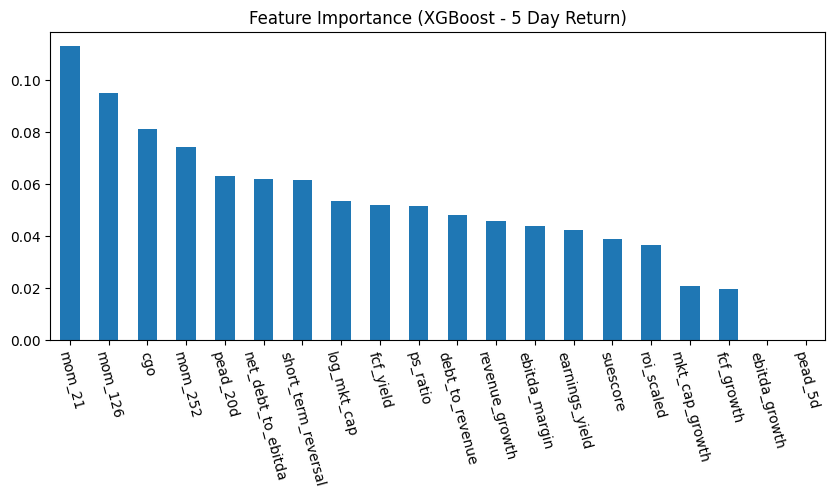

Top 10 Important Features: ['mom_21', 'mom_126', 'cgo', 'mom_252', 'pead_20d', 'net_debt_to_ebitda', 'short_term_reversal', 'log_mkt_cap', 'fcf_yield', 'ps_ratio']


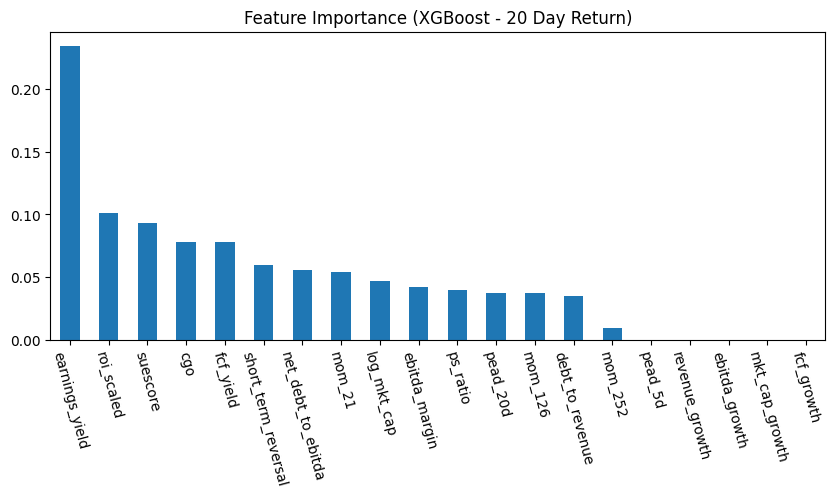

Top 10 Important Features: ['earnings_yield', 'roi_scaled', 'suescore', 'cgo', 'fcf_yield', 'short_term_reversal', 'net_debt_to_ebitda', 'mom_21', 'log_mkt_cap', 'ebitda_margin']


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [86]:
prediction_target_windows = [5, 20, 60]
feature_importance_dict = {}

ml_data = final_df.copy()

for w in prediction_target_windows:
    prediction_target_window = w

    ml_data['target_return'] = ml_data.groupby('ticker')['adj_close'].pct_change(prediction_target_window).shift(-prediction_target_window)

    ml_data.dropna(subset=['target_return'], inplace=True)

    ml_data = ml_data.dropna(subset=features + ['target_return'])

    X = ml_data[features]
    y = ml_data['target_return']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)

    feature_importance = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

    feature_importance_dict[w] = feature_importance

    plt.figure(figsize=(10, 4))
    feature_importance.plot(kind='bar')
    plt.xticks(rotation=-75) 
    plt.title(f"Feature Importance (XGBoost - {w} Day Return)")
    plt.show()

    top_features = feature_importance.index[:10].tolist()
    print("Top 10 Important Features:", top_features)

#### SC model

In [87]:
final_df.columns

Index(['ticker', 'date', 'adj_close', 'oftic', 'measure', 'fiscalp', 'pyear',
       'pmon', 'usfirm', 'anndats', 'actual', 'surpmean', 'surpstdev',
       'suescore', 'year', 'per_end_date', 'per_type', 'tot_revnu',
       'eps_diluted_net', 'basic_net_eps', 'tot_lterm_debt', 'net_lterm_debt',
       'net_curr_debt', 'tot_debt_tot_equity', 'ret_invst',
       'free_cash_flow_per_share', 'ebitda', 'shares_out', 'mkt_val',
       'valid_from', 'ref_price', 'cgo', 'mom_21', 'mom_126', 'mom_252',
       'short_term_reversal', 'pead_5d', 'pead_20d', 'ps_ratio',
       'earnings_yield', 'fcf_yield', 'ebitda_margin', 'roi_scaled',
       'eps_growth', 'net_debt_to_ebitda', 'debt_to_revenue', 'revenue_growth',
       'ebitda_growth', 'mkt_cap_growth', 'log_mkt_cap', 'fcf_growth',
       'target_return_5_day', 'target_return_20_day', 'target_return_60_day',
       'day_after_earnings', 'previous_day_return'],
      dtype='object')

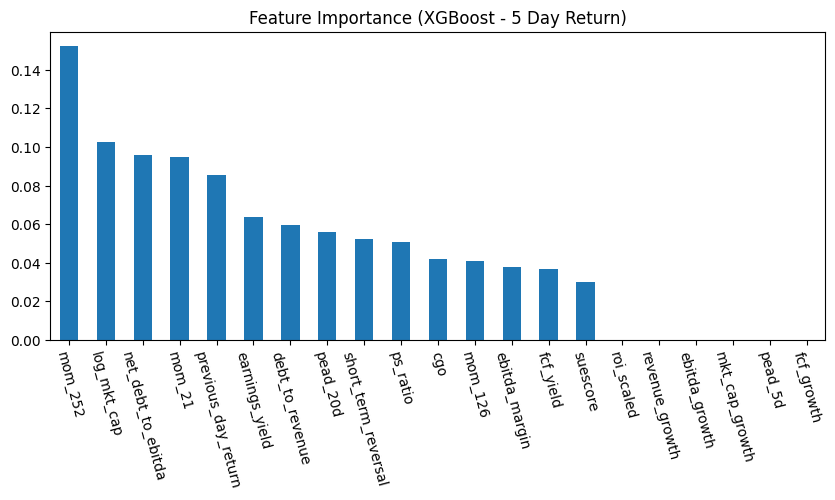

Top 10 Important Features: ['mom_252', 'log_mkt_cap', 'net_debt_to_ebitda', 'mom_21', 'previous_day_return', 'earnings_yield', 'debt_to_revenue', 'pead_20d', 'short_term_reversal', 'ps_ratio']


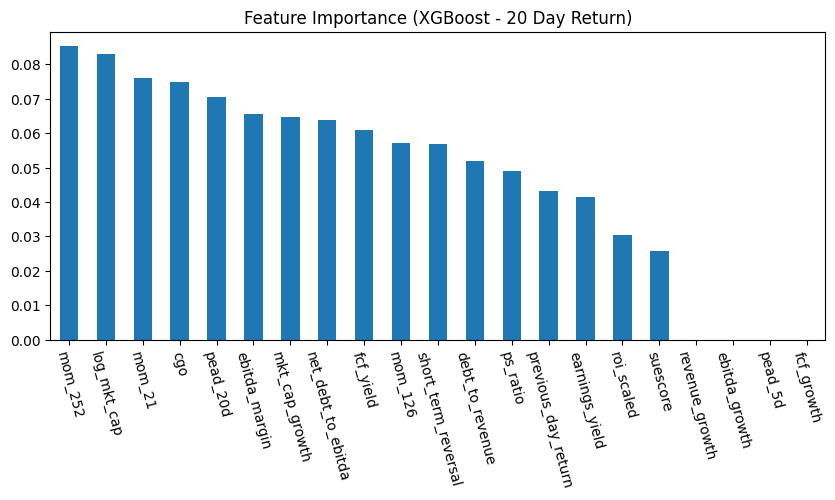

Top 10 Important Features: ['mom_252', 'log_mkt_cap', 'mom_21', 'cgo', 'pead_20d', 'ebitda_margin', 'mkt_cap_growth', 'net_debt_to_ebitda', 'fcf_yield', 'mom_126']


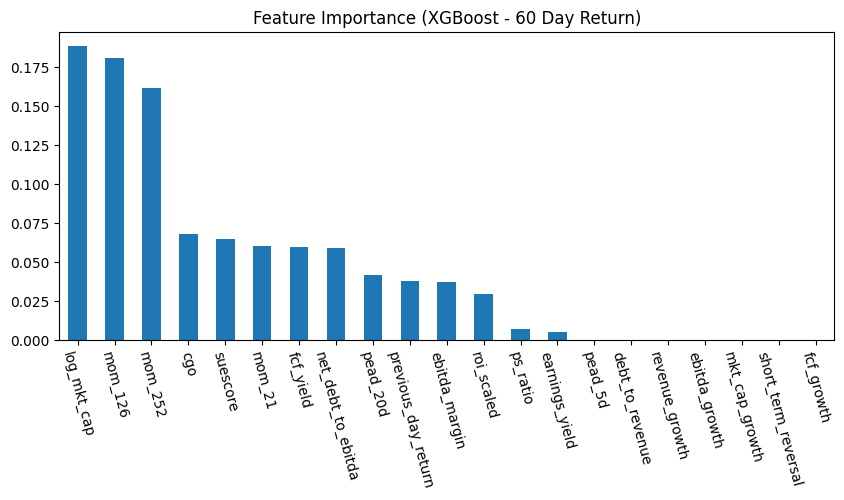

Top 10 Important Features: ['log_mkt_cap', 'mom_126', 'mom_252', 'cgo', 'suescore', 'mom_21', 'fcf_yield', 'net_debt_to_ebitda', 'pead_20d', 'previous_day_return']


In [90]:
validation_set = final_df.loc[final_df['date']>=pd.to_datetime('2024-01-01')].copy()
in_sample = final_df.loc[final_df['date']<pd.to_datetime('2024-01-01')].copy()
test_size = int(np.floor(len(in_sample) * 0.1))
test_set = in_sample.iloc[-test_size:]
training_set = in_sample.iloc[:-test_size]

req_cols = [
    'ticker',
    'date',
    'adj_close'
]
features = [
    'suescore',
    'cgo', 
    'mom_21', 'mom_126', 'mom_252','short_term_reversal', 
    'pead_5d', 'pead_20d', 
    'ps_ratio','earnings_yield', 'fcf_yield', 'ebitda_margin', 'roi_scaled',
    'net_debt_to_ebitda', 'debt_to_revenue', 'revenue_growth',
    'ebitda_growth', 'mkt_cap_growth', 'log_mkt_cap', 'fcf_growth', 'previous_day_return'
]
for w in prediction_target_windows:   
    
    test_size = int(np.floor(len(in_sample) * 0.1))
    X_train = training_set[features]
    y_train = training_set[f'target_return_{w}_day']
    X_test = test_set[features]
    y_test = test_set[f'target_return_{w}_day']
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    xgb_model = xgb.XGBRegressor(n_estimators=10, learning_rate=0.1, max_depth=5, random_state=42)
    xgb_model.fit(X_train_scaled, y_train)

    feature_importance = pd.Series(xgb_model.feature_importances_, index=features).sort_values(ascending=False)

    feature_importance_dict[w] = feature_importance

    plt.figure(figsize=(10, 4))
    feature_importance.plot(kind='bar')
    plt.xticks(rotation=-75) 
    plt.title(f"Feature Importance (XGBoost - {w} Day Return)")
    plt.show()

    top_features = feature_importance.index[:10].tolist()
    print("Top 10 Important Features:", top_features)


In [71]:
training_set.head()

,ticker,date,adj_close,oftic,measure,fiscalp,pyear,pmon,usfirm,anndats,actual,surpmean,surpstdev,suescore,year,per_end_date,per_type,tot_revnu,eps_diluted_net,basic_net_eps,tot_lterm_debt,net_lterm_debt,net_curr_debt,tot_debt_tot_equity,ret_invst,free_cash_flow_per_share,ebitda,shares_out,mkt_val,valid_from,ref_price,cgo,mom_21,mom_126,mom_252,short_term_reversal,pead_5d,pead_20d,target_return_5_day,target_return_20_day,target_return_60_day,day_after_earnings,previous_day_return
0,SLB,2019-01-18,38.161562,SLB,EPS,QTR,2018.0,12.0,1.0,2019-01-18,0.36,0.35564,0.01170,0.37228,2019.0,2018-09-30,Q,8504.00,0.46,0.46,14159.000,-680.000,-103.000,0.4702,1.2875,1.3240,1785.0000,1384.80,84362.02,2018-10-26,38.664135,-0.013170,0.168600,-0.377021,-0.536036,0.079298,0.082527,0.235635,-0.010955,0.029662,0.070360,2019-01-18,0.000000
1,VFC,2019-01-22,67.251991,VFC,EPS,QTR,2018.0,12.0,1.0,2019-01-18,1.31,1.09777,0.03034,6.99520,2019.0,2018-09-30,Q,3219.39,1.26,1.28,2150.595,-3.107,40.219,0.8904,6.5737,-0.0663,621.3491,396.81,37081.52,2018-11-02,63.862911,0.050394,0.129469,-0.116226,0.048122,0.132396,0.141561,0.167309,0.028250,0.056255,0.174917,2019-01-22,-0.006923
2,JNJ,2019-01-23,109.848885,JNJ,EPS,QTR,2018.0,12.0,1.0,2019-01-22,1.97,1.95181,0.01481,1.22839,2019.0,2018-09-30,Q,20348.00,1.44,1.44,29480.000,-904.000,-2325.000,0.4836,4.1804,5.3160,6572.0000,2681.98,370569.16,2018-11-02,116.812080,-0.063389,0.004123,0.029986,-0.113180,-0.004338,-0.004329,0.005543,0.022050,0.051398,0.074757,2019-01-23,0.000000
3,ATI,2019-01-23,26.440000,ATI,EPS,QTR,2018.0,12.0,1.0,2019-01-22,0.31,0.34455,0.03725,-0.92749,2019.0,2018-09-30,Q,1020.20,0.37,0.40,1535.300,2.500,4.000,0.7450,1.5365,0.1144,133.3000,125.68,3713.96,2018-11-02,25.077692,0.051524,0.183836,-0.013524,-0.064089,0.079885,0.083163,0.216191,0.031392,0.085098,-0.027231,2019-01-23,0.032812
4,IBM,2019-01-23,95.875301,IBM,EPS,QTR,2018.0,12.0,1.0,2019-01-22,4.87,4.81706,0.10123,0.52299,2019.0,2018-09-30,Q,18756.00,2.94,2.95,35989.000,468.000,376.000,2.3557,4.8151,9.5138,4327.0000,908.79,137418.75,2018-11-01,86.571425,0.097041,0.161957,-0.068597,-0.157280,0.087716,0.091678,0.197855,0.011212,0.049476,0.068434,2019-01-23,0.084639


## Data Analysis

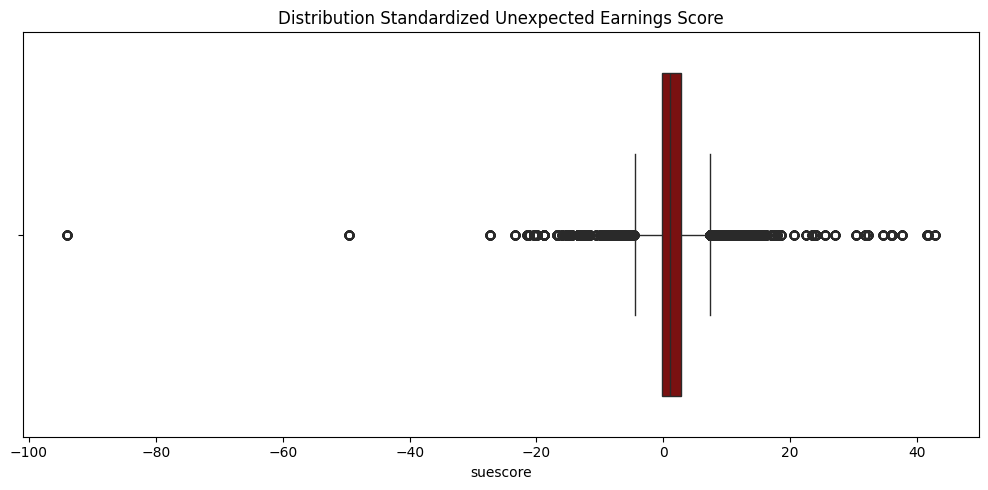

In [122]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=final_df['suescore'], orient='h', color='darkred')
ax.set_title('Distribution Standardized Unexpected Earnings Score')
plt.tight_layout()
plt.show()

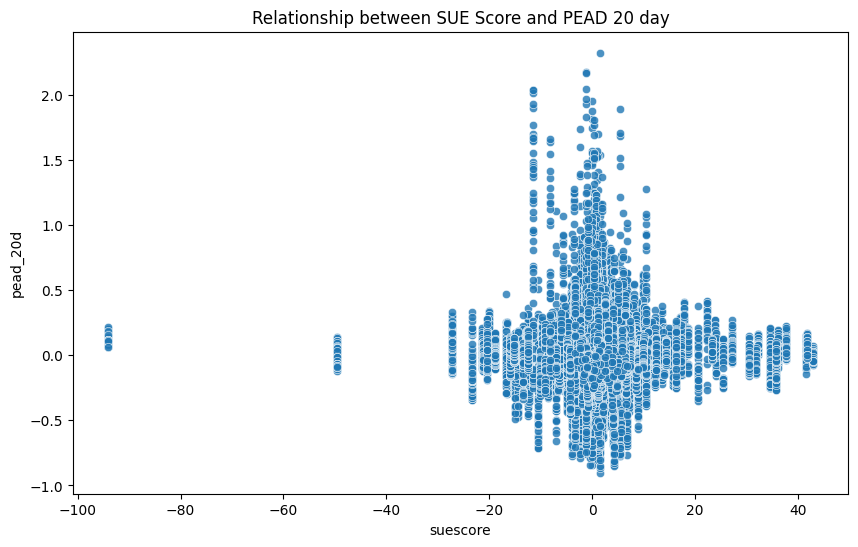

In [123]:
plt.figure(figsize=(10, 6))

plot_df = final_df.copy()

sns.scatterplot(
    x='suescore', 
    y='pead_20d', 
    data=plot_df, 
    palette='tab10',
    alpha=0.8  
)

plt.xlabel('suescore')
plt.ylabel('pead_20d')
plt.title('Relationship between SUE Score and PEAD 20 day')

plt.show()

sue_quantile
Low     0.004263
Q2      0.009906
Q3      0.015442
Q4      0.018446
High    0.021646
Name: pead_20d, dtype: float64


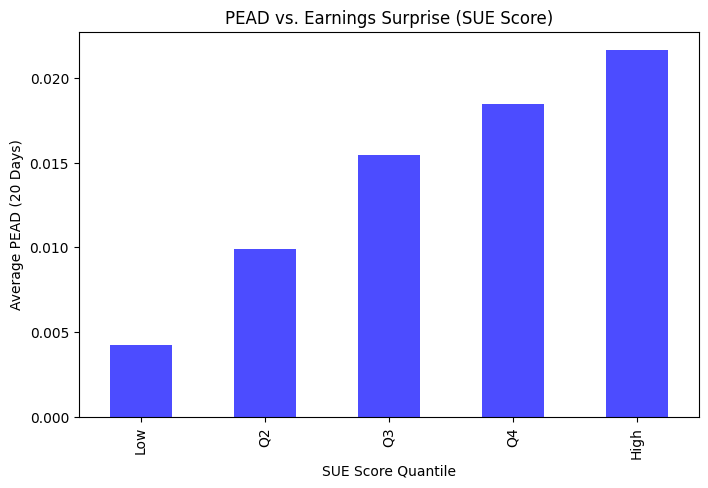

In [124]:
final_df['sue_quantile'] = pd.qcut(final_df['suescore'], q=5, labels=['Low', 'Q2', 'Q3', 'Q4', 'High'])

sue_pead_summary = final_df.groupby('sue_quantile')['pead_20d'].mean()
print(sue_pead_summary)

plt.figure(figsize=(8,5))
sue_pead_summary.plot(kind='bar', color='blue', alpha=0.7)
plt.xlabel("SUE Score Quantile")
plt.ylabel("Average PEAD (20 Days)")
plt.title("PEAD vs. Earnings Surprise (SUE Score)")
plt.show()

## Strategy Implementation

## Backtesting

## Performance Analysis

## References